In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/jacobgil/pytorch-grad-cam
%cd pytorch-grad-cam
!pip install .

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 802, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 802 (delta 43), reused 68 (delta 33), pack-reused 702
Receiving objects: 100% (802/802), 17.11 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (423/423), done.
/content/pytorch-grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/pytorch-grad-cam
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Prep

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import datasets, models, transforms

import os
import copy
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm
from multiprocessing.pool import Pool
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report

cudnn.benchmark = True
plt.ion()   # interactive mode

model_resnet = models.resnet50(pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

cnt = 0
for param in model_resnet.parameters():
    if cnt < 161 * 3 // 4:
        param.requires_grad = False
    else:
        break
    cnt += 1
num_ftrs    = model_resnet.fc.in_features  
model_resnet.fc = nn.Linear(num_ftrs, 3) 
model_resnet    = model_resnet.to(device)

model_resnet.load_state_dict(torch.load('/content/drive/MyDrive/COURSES/CS331/FinalProject/ResNet50.pt', map_location=torch.device('cpu'))) 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [4]:
import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
methods = {"gradcam": GradCAM,
        "scorecam": ScoreCAM,
        "gradcam++": GradCAMPlusPlus,
        "ablationcam": AblationCAM,
        "xgradcam": XGradCAM,
        "eigencam": EigenCAM,
        "eigengradcam": EigenGradCAM,
        "layercam": LayerCAM,
        "fullgrad": FullGrad}

model = model_resnet
image_path = '/content/drive/MyDrive/COURSES/CS331/FinalProject/Demo/demo/demo.jpeg'

if cv2.imread(image_path) is None:
    raise Exception('Image not found')

target_layers = [model.layer4]

rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
targets = None
cam_algorithm = methods['gradcam++']
with cam_algorithm(model=model_resnet,
                    target_layers=target_layers,
                    use_cuda=False) as cam:

    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        aug_smooth=False,
                        eigen_smooth=False)

    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

gb_model = GuidedBackpropReLUModel(model=model, use_cuda=False)
gb = gb_model(input_tensor, target_category=None)

cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_gb = deprocess_image(cam_mask * gb)
gb = deprocess_image(gb)

In [5]:
data_transforms = {
    'Demo': transforms.Compose([ 
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(), 
                transforms.Normalize(
                    [0.485, 0.456, 0.406], 
                    [0.229, 0.224, 0.225]
                )
    ]),
}

data_dir = '/content/drive/MyDrive/COURSES/CS331/FinalProject/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Demo']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=4)
                for x in ['Demo']}
                
dataset_sizes = {x: len(image_datasets[x]) for x in ['Demo']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Label of CXR image: Bacteria


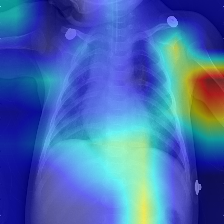

In [6]:
from google.colab.patches import cv2_imshow
label = {
    0: 'Bacteria',
    1: 'Normal',
    2: 'Virus', 
}
for inputs, labels in tqdm.tqdm(dataloaders['Demo']): 
    out = model_resnet(inputs)  
    _, preds = torch.max(out, 1)
    print(f"Label of CXR image: {label[int(np.squeeze(preds.cpu().numpy().T))]}")
cv2.imwrite('/content/visualize.png', cam_image)
cv2_imshow(cam_image)